In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from lyft_dataset_sdk.lyftdataset import LyftDataset
import matplotlib.pyplot as plt
from prepare_lyft_data import parse_train_csv,get_pc_in_image_fov,level5data,parse_string_to_box

/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d

In [3]:
import pickle

In [4]:
pred_file="/Users/kanhua/Dropbox/Programming/lyft-3d-main/train_val_pred.csv"

In [5]:
import pandas as pd
val_df=pd.read_csv(pred_file,index_col="Id")

In [6]:
val_df.head()

,PredictionString
Id,
8c439f82aa3a03cac82b8e482ae6d5ad39985a2b75df88ca8aea4361fa3cfe63,-0.03802166226564582 1651.729590162752 1339.39...
1e64c3b0f398847d034feac29743d0c081fdf7a5a2067d543ffe9be6052f2cc7,-0.08786185088593439 1658.202414663248 1331.41...
94d336303651ec8066fc530b7020adbe5a5ded16de987b1d9dea656dbe3961d3,-0.8160236546092725 1664.6341484178013 1343.29...
efbfe8df6fbf8afda5f394cc9667b8755ed8c461ea7fd36a401433b44cfa1558,-0.03984453818252975 1652.425771792261 1334.88...
8370bf03d0e5430eeab251ffa1437addc9be42268969d9284918991a7f9943fd,-0.037312388494103066 1649.6059127659373 1336....


In [9]:
data_idx=0
sample_token=val_df.index[data_idx]
boxes_str=val_df.loc[sample_token,'PredictionString']

In [10]:
boxes=parse_string_to_box(boxes_str)

In [11]:
sample_record=level5data.get("sample",sample_token)

In [12]:
from skimage.io import imread

In [13]:
from prepare_lyft_data import transform_box_from_world_to_sensor_coordinates,get_train_data_sample_token_and_box

In [14]:
lidar_top_token=sample_record['data']['LIDAR_TOP']
lidar_path=level5data.get_sample_data_path(lidar_top_token)

In [15]:
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud

In [16]:
lpc=LidarPointCloud.from_file(lidar_path)

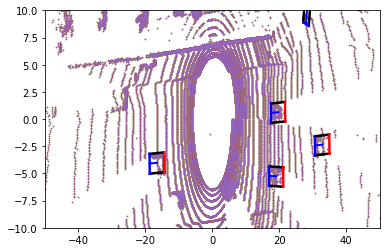

In [27]:
fig,ax=plt.subplots()
for pred_box in boxes:
    box_in_lidar_coord=transform_box_from_world_to_sensor_coordinates(pred_box,lidar_top_token,level5data)

    pts=lpc.points
    ax.scatter(pts[0,:],pts[1,:],s=0.1)
    ax.set_xlim([-50,50])
    ax.set_ylim([-10,10])
    view_mtx=np.eye(2)
    box_in_lidar_coord.render(ax,view=view_mtx)

In [21]:
camera_token=sample_record['data']['CAM_BACK']

In [22]:
camera_image_path,_,cam_intrinsic=level5data.get_sample_data(camera_token)

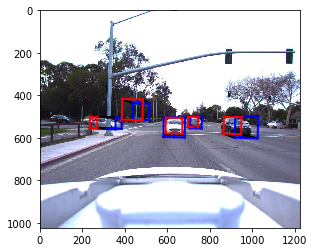

In [23]:
image_array=imread(camera_image_path)
fig,ax=plt.subplots()
ax.imshow(image_array)
for pred_box in boxes:
    box_in_camera_coord=transform_box_from_world_to_sensor_coordinates(pred_box,camera_token,level5data)
    box_in_camera_coord.render(ax,view=cam_intrinsic,normalize=True)

## Show ground truth data

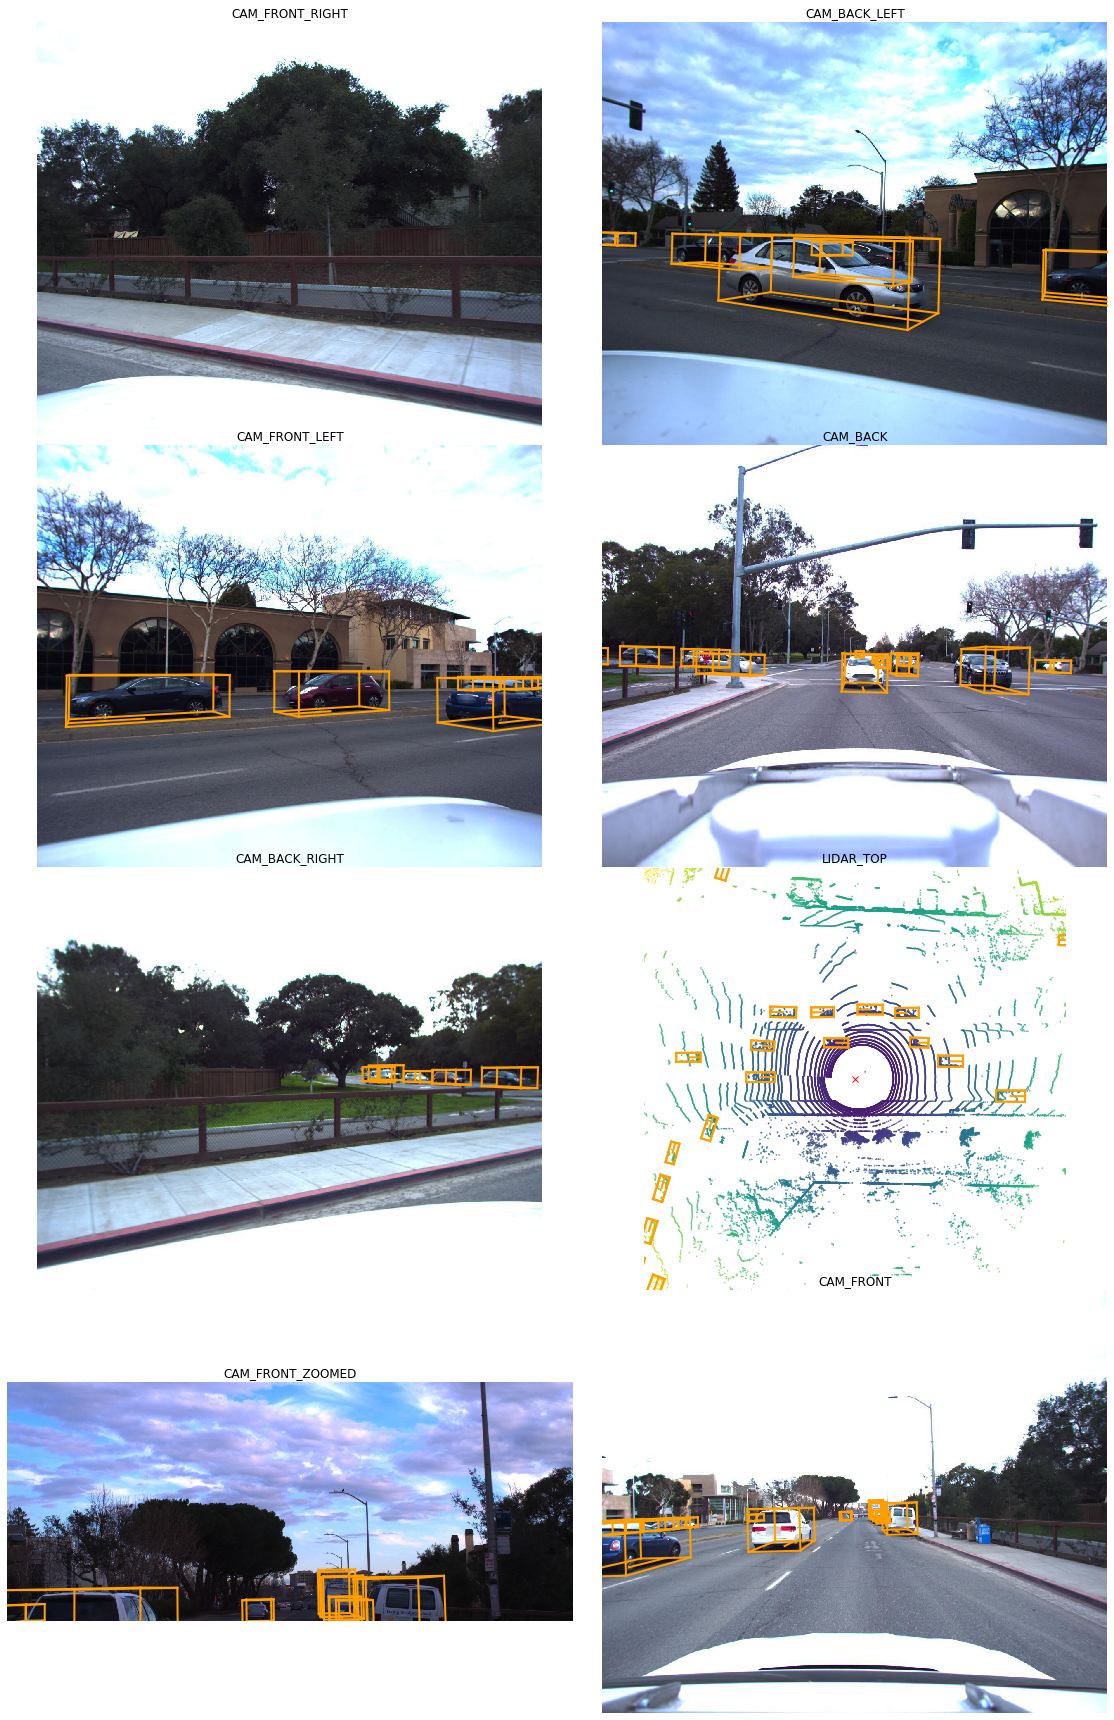

In [24]:
level5data.render_sample(sample_token=sample_token)

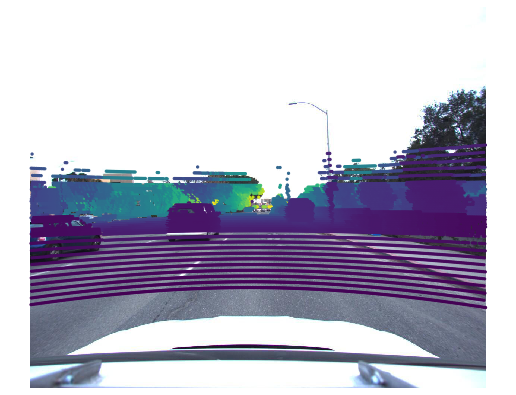

In [25]:
level5data.render_pointcloud_in_image(sample_token)

In [ ]:
pred_obj.iloc[15,:]

In [ ]:
pred_obj.iloc[14,:]

In [ ]:
pred_obj.iloc[17,:]

In [ ]:
from object_classifier import TLClassifier
from vis_util import draw_bounding_boxes_on_image_array,draw_bounding_box_on_image_array

In [ ]:
tlc=TLClassifier()

In [ ]:
det_box=tlc.detect_multi_object(image_array,score_threshold=[0.6,0.6,0.6],rearrange_to_pointnet_convention=False)
det_box

In [ ]:
image_to_draw=np.copy(image_array)
det_box=det_box[:,0:4]
draw_bounding_boxes_on_image_array(image_to_draw,det_box)
plt.imshow(image_to_draw)

In [ ]:
det_box=tlc.detect_multi_object(image_array,score_threshold=[0.6,0.6,0.6],rearrange_to_pointnet_convention=True)
mask, pc_3d, pc_2d, lpc, img=get_pc_in_image_fov(lidar_top_token,'CAM_FRONT',level5testdata,bounding_box=det_box[1,0:4])

In [ ]:
pc_2d.shape

In [ ]:
fig,ax=plt.subplots()
ax.imshow(img)
ax.scatter(pc_2d[0,:],pc_2d[1,:])

In [ ]:
image_array.shape